# Backpropagtion with TensorFlow
- SGD with 1 layer NN
- didn't use train/test split
- Reference: 
https://github.com/hunkim/DeepLearningZeroToAll/blob/master/lab-09-5-softmax_back_prop.py

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Reproducibility
tf.set_random_seed(777)
np.random.seed(777)

### Read Data

In [3]:
data_path = '../datasets/zoo.csv'

In [4]:
xy = np.loadtxt(data_path, delimiter=',', dtype=np.float32)
xy

array([[ 1.,  0.,  0., ...,  0.,  1.,  1.],
       [ 1.,  0.,  0., ...,  0.,  1.,  1.],
       [ 0.,  0.,  1., ...,  0.,  0.,  4.],
       ..., 
       [ 1.,  0.,  0., ...,  0.,  1.,  1.],
       [ 0.,  0.,  1., ...,  0.,  0.,  7.],
       [ 0.,  1.,  1., ...,  0.,  0.,  2.]], dtype=float32)

In [5]:
xy.shape

(101, 17)

In [6]:
def print_and_shape(name, x):
    try:
        # numpy array
        print(f'{name}: {x.shape}')
    except:
        # tensor
        print(f'{name}: {x.get_shape()}')

In [7]:
x_data = xy[:, :-1]
y_data = xy[:, -1]
print_and_shape('x_data', x_data)
print(f'x_data: {x_data.shape}')
print(f'y_data: {y_data.shape}')

x_data: (101, 16)
x_data: (101, 16)
y_data: (101,)


### Hyperparameters

In [8]:
data_size, n_dim = x_data.shape # 101, 16
n_classes = 7
n_epoch = 5000
batch_size = 30
n_step = data_size // batch_size
learning_rate = 0.0005

### Placeholders

In [9]:
X = tf.placeholder(tf.float32, [None, n_dim])
Y = tf.placeholder(tf.int32, [None, 1])
print(f'X: {X.get_shape()}')
print(f'Y: {Y.get_shape()}')

X: (?, 16)
Y: (?, 1)


In [10]:
Y_one_hot = tf.one_hot(Y, n_classes)
Y_one_hot = tf.reshape(Y_one_hot, [-1, n_classes])
Y_one_hot = tf.cast(Y_one_hot, tf.float32)
print(f'Y_one_hot: {Y_one_hot.get_shape()}')

Y_one_hot: (?, 7)


### Model
- one layer perceptron

In [11]:
W = tf.Variable(tf.random_normal([n_dim, n_classes]), name='weight')
b = tf.Variable(tf.random_normal([n_classes]), name='bias')
print(f'W: {W.get_shape()}')
print(f'b: {b.get_shape()}')

W: (16, 7)
b: (7,)


### Activation Function
- sigmoid

In [12]:
def sigmoid(x):
    return 1. / (1. + tf.exp(-x))

In [13]:
def d_sigmoid(x):
    return sigmoid(x) * (1. - sigmoid(x))

### Forward Propagation

In [14]:
layer1 = tf.matmul(X, W) + b
y_pred = sigmoid(layer1)
print(f'layer1: {layer1.get_shape()}')
print(f'y_pred: {y_pred.get_shape()}')

layer1: (?, 7)
y_pred: (?, 7)


### Loss

In [15]:
diff = y_pred - Y_one_hot
loss = 0.5 * tf.reduce_sum(tf.square(diff))
print(f'diff: {diff.get_shape()}')
print(f'loss: {loss.get_shape()}')

diff: (?, 7)
loss: ()


### Back Propagation

$loss\quad =\quad \frac{1}{2} \sum\ (y_{pred} - y_{one\_hot})^2$

$\frac{\mathrm d loss}{\mathrm d y_{pred}}\quad =\quad y_{pred} - y_{one\_hot}\quad (=diff)$

In [16]:
dloss_dypred = diff
print_and_shape('dloss_dypred', dloss_dypred)

dloss_dypred: (?, 7)


${ y }_{ pred }\quad =\quad \sigma (layer_{1}) $

$\frac{\mathrm d y _{ pred }}{\mathrm d layer_{ 1 }}\quad =\quad \sigma' (layer1)$

In [17]:
dypred_dlayer1 = d_sigmoid(layer1)
print_and_shape('dypred_dlayer1', dypred_dlayer1)

dypred_dlayer1: (?, 7)


$\frac{\mathrm d loss}{\mathrm d layer_{ 1 }} = \frac{\mathrm d loss}{\mathrm d y_{pred}} \cdot \frac{\mathrm d y _{ pred }}{\mathrm d layer_{ 1 }}$

In [18]:
dloss_dlayer1 = dloss_dypred * dypred_dlayer1
print_and_shape('dloss_dlayer1', dloss_dlayer1)

dloss_dlayer1: (?, 7)


$layer_{1}\quad =\quad XW + b$

$\frac{\mathrm d layer _{ 1 }}{\mathrm d w}\quad =\quad X^T$

$\frac{\mathrm d layer _{ 1 }}{\mathrm d b}\quad =\quad 1$

In [19]:
dlayer1_dw = tf.transpose(X)
dlayer1_db = tf.ones(n_classes)
print_and_shape('dlayer1_dw', dlayer1_dw)
print_and_shape('dlayer1_db', dlayer1_db)

dlayer1_dw: (16, ?)
dlayer1_db: (7,)


$\frac{\mathrm d loss}{\mathrm d w}\quad =\quad \frac{\mathrm d layer_{1}}{\mathrm d w} \cdot \frac{\mathrm d loss}{\mathrm d layer_{ 1 }}$

$\frac{\mathrm d loss}{\mathrm d b}\quad =\quad \frac{\mathrm d layer_{1}}{\mathrm d b} \cdot \frac{\mathrm d loss}{\mathrm d layer_{ 1 }}$

In [20]:
dloss_dw = tf.matmul(dlayer1_dw, dloss_dlayer1)
dloss_db = tf.reduce_mean(dlayer1_db * dloss_dlayer1, 0) # loss from all data in batch
print_and_shape('dloss_dw', dloss_dw)
print_and_shape('dloss_db', dloss_db)

dloss_dw: (16, 7)
dloss_db: (7,)


### helper functions
- backprop_ops
- accuracy
- batch

In [21]:
backprop_ops = [
    tf.assign(W, W - learning_rate * dloss_dw),
    tf.assign(b, b - learning_rate * dloss_db)
]

In [22]:
prediction = tf.argmax(y_pred, 1)
true_label = tf.argmax(Y_one_hot, 1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, true_label), tf.float32))

In [23]:
def get_batch(x_data, y_data):
    indices = np.random.choice(data_size, batch_size)
    x_batch = x_data[indices]
    y_batch = y_data[indices].reshape(-1 ,1)
    return x_batch, y_batch

### Run Model

In [24]:
with tf.Session() as sess:
    # initialization
    sess.run(tf.global_variables_initializer())
    global_accuracy_history = []

    # Train
    for epoch in range(n_epoch):
        for step in range(n_step):
            # get batch
            x_batch, y_batch = get_batch(x_data, y_data)
            
            # run backprop
            sess.run(backprop_ops, feed_dict={X: x_batch, Y: y_batch})
            
            # check batch_accuracy
            batch_accuracy = sess.run(accuracy, feed_dict={X: x_batch, Y: y_batch})
            # print(f'epoch: {epoch}, step: {step} | accuracy: {batch_accuracy:.4}')
            global_accuracy_history.append(batch_accuracy)
            
    print('Training Done!\n')

    # Test
    final_accuracy = sess.run(accuracy, feed_dict={X: x_data, Y: y_data.reshape(-1, 1)})
    print(f'Final accuracy: {final_accuracy:.4}')

#     pred = sess.run(prediction, feed_dict={X: x_data})
#     for p, y in zip(pred, y_data):
#         y = int(y)
#         if p == y:
#             print(f'Correct!\t Prediction: {p}\t True label: {y}')
#         else:
#             print(f'False!\t Prediction: {p}\t True label: {y}')

Training Done!

Final accuracy: 0.8416


### Training Overview

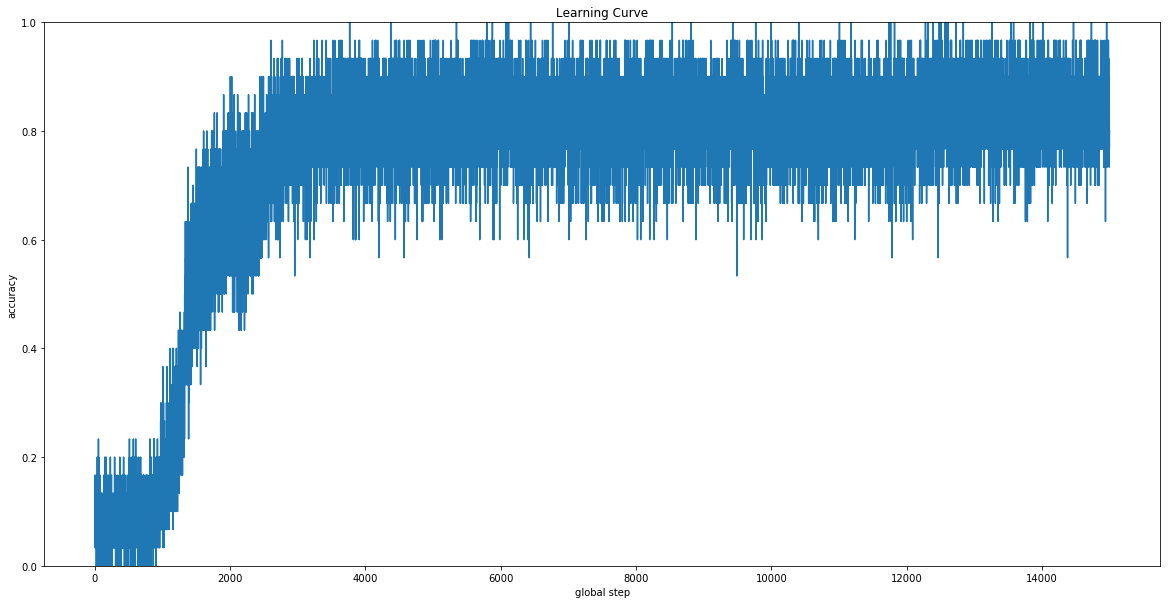

In [25]:
plt.figure(figsize=(20, 10))
plt.title('Learning Curve')
plt.xlabel('global step')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.plot(range(n_epoch*n_step), global_accuracy_history)
plt.show()